# C5. SUPPORT VECTOR REGRESSION

__5.1 Importing Libraries and Datasets__

__5.2 Support Vector Regression__

__5.3 Model Evaluation : Training Metrics__

__5.4 Model Evaluation : Cross Validation__

__5.5 Model Evaluation : Test Dataset__

__5.6 Feature Importances__

__5.7 Residuals' Distribution__

__5.8 Scatterplots with fitted line (Train Dataset)__

__5.9 Saving Results__

## 5.1 Importing Libraries and Datasets

In [1]:
# Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [2]:
# Train Dataset

train_data = pd.read_csv("BG_Train_Dataset.csv") 
train_df = train_data.copy()
train_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.346,4.337,1.549,5.791,7.307,1,1,1,2,129


In [3]:
# Test Dataset

test_data = pd.read_csv("BG_Test_Dataset.csv") 
test_df = test_data.copy()
test_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,4.165,5.322,0.0,8.05,6.734,0,0,1,3,130


## 5.2 Support Vector Regression

In [4]:
# Defining X_train and Y_train

Y_train = train_df['Post Operative Glucose']
X_train = train_df.drop('Post Operative Glucose', axis = 1)
X_train.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.346,4.337,1.549,5.791,7.307,1,1,1,2


In [5]:
# Using the KFold function for cross-validation

cv = KFold(n_splits = 5, shuffle = True, random_state = 126)

In [6]:
# Defining Grid for Hyperparameter Tuning

grid = {'kernel' : ['poly','sigmoid','linear', 'rbf'],
       'degree' : [2,3],
       'gamma' : [0.001, 0.005, 0.01, 0.05, 'scale', 'auto'],
       'coef0' : [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 5],
       'C' : [0.5, 1, 1.5, 2, 2.5, 3],
       'epsilon' : [0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
       'shrinking' : [True, False],
       'max_iter' : [-1]}

In [7]:
# Instantiating GridSearchCV 

SVR_search = GridSearchCV(SVR(), 
                            grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1 ,verbose = 0)

In [8]:
# Searching for the best parameters for SVR

CV_SVR_results = SVR_search.fit(X_train, Y_train)

In [9]:
# Displaying the best parameters 

SVR_Best_Parameters = pd.DataFrame(CV_SVR_results.best_params_,
                                        index = ['Best SVR Parameters'])

SVR_Best_Parameters = SVR_Best_Parameters.transpose()
SVR_Best_Parameters

,Best SVR Parameters
C,1
coef0,2
degree,3
epsilon,0.001
gamma,0.05
kernel,poly
max_iter,-1
shrinking,True


In [10]:
# Storing the values of the best parameters

best_kernel = CV_SVR_results.best_params_['kernel']
best_degree = CV_SVR_results.best_params_['degree']
best_gamma = CV_SVR_results.best_params_['gamma']
best_coef0 = CV_SVR_results.best_params_['coef0']
best_C = CV_SVR_results.best_params_['C']
best_epsilon = CV_SVR_results.best_params_['epsilon']
best_shrinking = CV_SVR_results.best_params_['shrinking']
best_max_iter = CV_SVR_results.best_params_['max_iter']

## 5.3 Model Evaluation : Training Metrics

In [11]:
# Instantiating the best SVR Model

SVRModel = SVR(kernel = best_kernel,
              degree = best_degree,
              gamma = best_gamma,
              coef0 = best_coef0,
              C = best_C,
              epsilon = best_epsilon,
              shrinking = best_shrinking,
              max_iter = best_max_iter).fit(X_train,Y_train)

In [12]:
# Getting the R^2

SVR_R2 = np.round(SVRModel.score(X_train,Y_train),3)

In [13]:
# Getting predictions and training metrics 

SVRPredictions = SVRModel.predict(X_train)
SVRFeats = SVRModel.n_features_in_
SVR_Tr_MAE = np.round(mean_absolute_error(Y_train, SVRPredictions),3)


In [14]:
# Dictionary the holds the information of  R^2, number of predictors and training metrics

dict1 = {'Support Vector Regression' : [SVR_R2, SVRFeats, SVR_Tr_MAE]}

In [15]:
# Creating a dataframe to easily present the results 

Training_metric_df = pd.DataFrame(dict1, index=['R^2','Num_of_Feats','Tr_MAE'])

In [16]:
# Displaying the training evaluation metrics

Training_metric_df

,Support Vector Regression
R^2,0.439
Num_of_Feats,9.000
Tr_MAE,15.820


## 5.4 Model Evaluation : Cross Validation

In [17]:
# Function that calculates the cross validated test MAE  

def cv_scores(X,Y, model,cv):
        
    cv_MAE = round(np.mean(cross_val_score(model, X, Y, cv=cv, 
                                       scoring='neg_mean_absolute_error', 
                                           error_score='raise') * (-1)),2)

    
    score = cv_MAE
    return score

In [18]:
# Dictionary that holds the information of the cross validated test MAE  

dict2 = {'Support Vector Regression':cv_scores(X_train,Y_train, SVRModel,cv)}

In [19]:
# Creating a dataframe to easily present the results 

Test_CV_results = pd.DataFrame(dict2, index=['Te_MAE (KFold)'])

# Displaying the cross validated test error results

Test_CV_results

,Support Vector Regression
Te_MAE (KFold),17.69


## 5.5 Model Evaluation : Test Dataset

In [20]:
# Defining X_test and Y_test

Y_test = test_df['Post Operative Glucose']
X_test = test_df.drop('Post Operative Glucose', axis = 1)
X_test.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,4.165,5.322,0.0,8.05,6.734,0,0,1,3


In [21]:
# Getting predictions

SVR_predictions = SVRModel.predict(X_test)

In [22]:
# Getting Test Metrics

SVR_Te_MAE = round(mean_absolute_error(Y_test, SVR_predictions),2)

In [23]:
# Dictionary that holds the information of test MAE 

dict3 = {'Support Vector Regression':[SVR_Te_MAE]}

In [24]:
# Creating a dataframe to easily present the results 

Test_Dat_results = pd.DataFrame(dict3, index=['Te_MAE'])

In [25]:
# Displaying the test error results

Test_Dat_results

,Support Vector Regression
Te_MAE,18.67


## 5.6 Feature Importances

In [26]:
# load JS visualization code to notebook

shap.initjs()

In [27]:
# Instantiating and fitting the best model 

model = SVR(kernel = best_kernel,
              degree = best_degree,
              gamma = best_gamma,
              coef0 = best_coef0,
              C = best_C,
              epsilon = best_epsilon,
              shrinking = best_shrinking,
              max_iter = best_max_iter)

model.fit(X_train, Y_train);

In [28]:
# Creating the explainer

explainer = shap.KernelExplainer(model.predict, X_train);

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [29]:
# Calculate Shapley values for the data

shap_values = explainer.shap_values(X_train)

  0%|          | 0/200 [00:00<?, ?it/s]

In [30]:
# Picking a color for the graphs

color = 'skyblue'

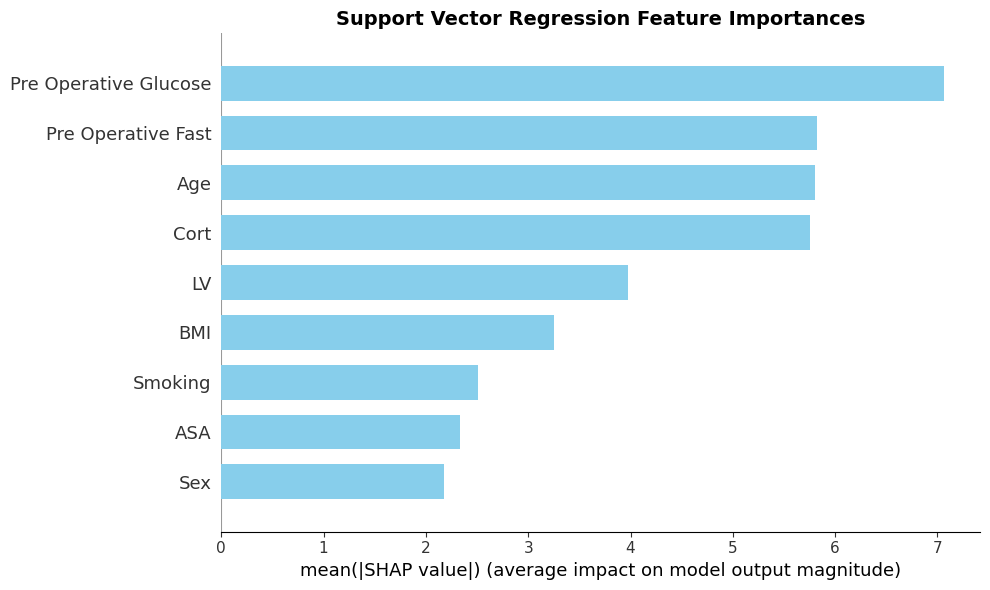

In [31]:
# Plot summary plot to visualize feature importance
plt.title(label = "Support Vector Regression Feature Importances" , fontsize = 14, weight = 'bold')

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, 
                  plot_type='bar', 
                  color=color, plot_size= (10,6))

plt.show()

## 5.7 Residuals' Distribution

In [32]:
# Models' fitted values

fitted_y1 = SVRPredictions

# Models' residuals

residuals1 = Y_train - SVRPredictions

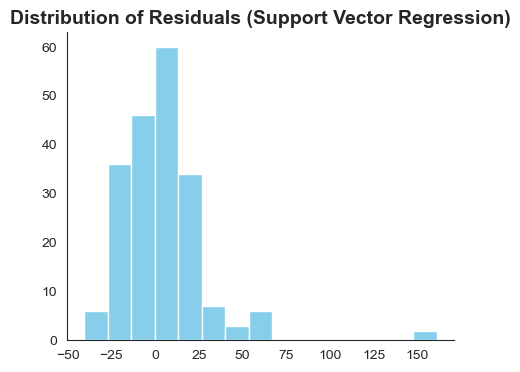

In [33]:
# Histogram of residuals 

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals1, bins = 15, color = color)
    
plt.title(label = "Distribution of Residuals (Support Vector Regression)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

## 5.8 Scatterplots with fitted line (Train Dataset)

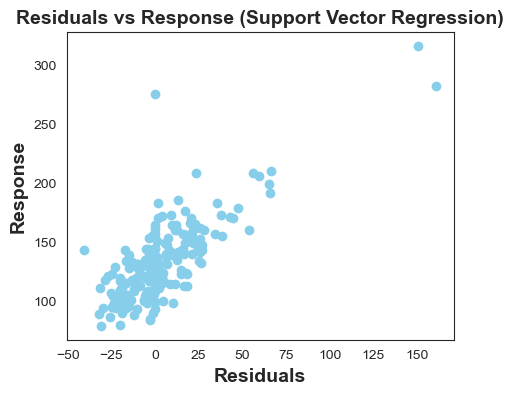

In [34]:
# Plotting residuals vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(residuals1, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(residuals1, Y_train, 1)

# plt.plot(residuals1, b*residuals1 + a, color = 'black')

plt.title(label = 'Residuals vs Response (Support Vector Regression)', fontsize = 14, weight = 'bold')
plt.xlabel('Residuals',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.show()

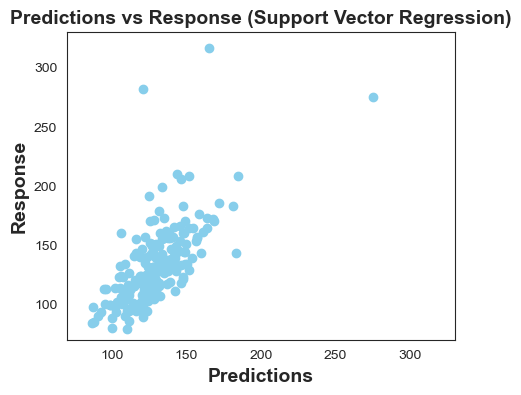

In [35]:
# Plotting predictions vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(SVRPredictions, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(SVRPredictions, Y_train, 1)

# plt.plot(SVRPredictions, b*SVRPredictions + a, color = 'black')

plt.title(label = 'Predictions vs Response (Support Vector Regression)', fontsize = 14, weight = 'bold')
plt.xlabel('Predictions',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.xlim(70, 330)
plt.ylim(70, 330)

plt.show()

## 5.9 Saving Results

In [36]:
# Concatenating the training and test Dataframes

SVRResults = pd.concat([Training_metric_df, Test_CV_results,Test_Dat_results], axis =  0)
SVRResults

,Support Vector Regression
R^2,0.439
Num_of_Feats,9.000
Tr_MAE,15.820
Te_MAE (KFold),17.690
Te_MAE,18.670


In [37]:
# Saving the Results

SVRResults.to_csv(r'SVRResults.csv', index=True, index_label = 'Metric')